In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2025-07-07')

In [3]:
# Load historical data for S&P 500
spx_data = yf.Ticker("^GSPC").history(start=start_date, end=end_date)
spx_data.index = pd.to_datetime(spx_data.index.date)

spx = spx_data['Close']
# Calculate daily returns
spx_returns = spx.pct_change().dropna()
rlsd_vol = spx_returns.rolling(window=5).std() * np.sqrt(252)

data = pd.DataFrame({
    'SPX': spx,
    'SPX Returns': spx_returns,
    'rlsd_vol': rlsd_vol
})

data.head(10)

,SPX,SPX Returns,rlsd_vol
2015-01-02,2058.199951,NaN,NaN
2015-01-05,2020.579956,-0.018278,NaN
2015-01-06,2002.609985,-0.008893,NaN
2015-01-07,2025.900024,0.011630,NaN
2015-01-08,2062.139893,0.017888,NaN
2015-01-09,2044.810059,-0.008404,0.242277
2015-01-12,2028.260010,-0.008094,0.205000
2015-01-13,2023.030029,-0.002579,0.190530
2015-01-14,2011.270020,-0.005813,0.175117
2015-01-15,1992.670044,-0.009248,0.042765


Average business days between observations: 1.45
Delta = 0.08333333333333333 years, which is approximately 21 trading days


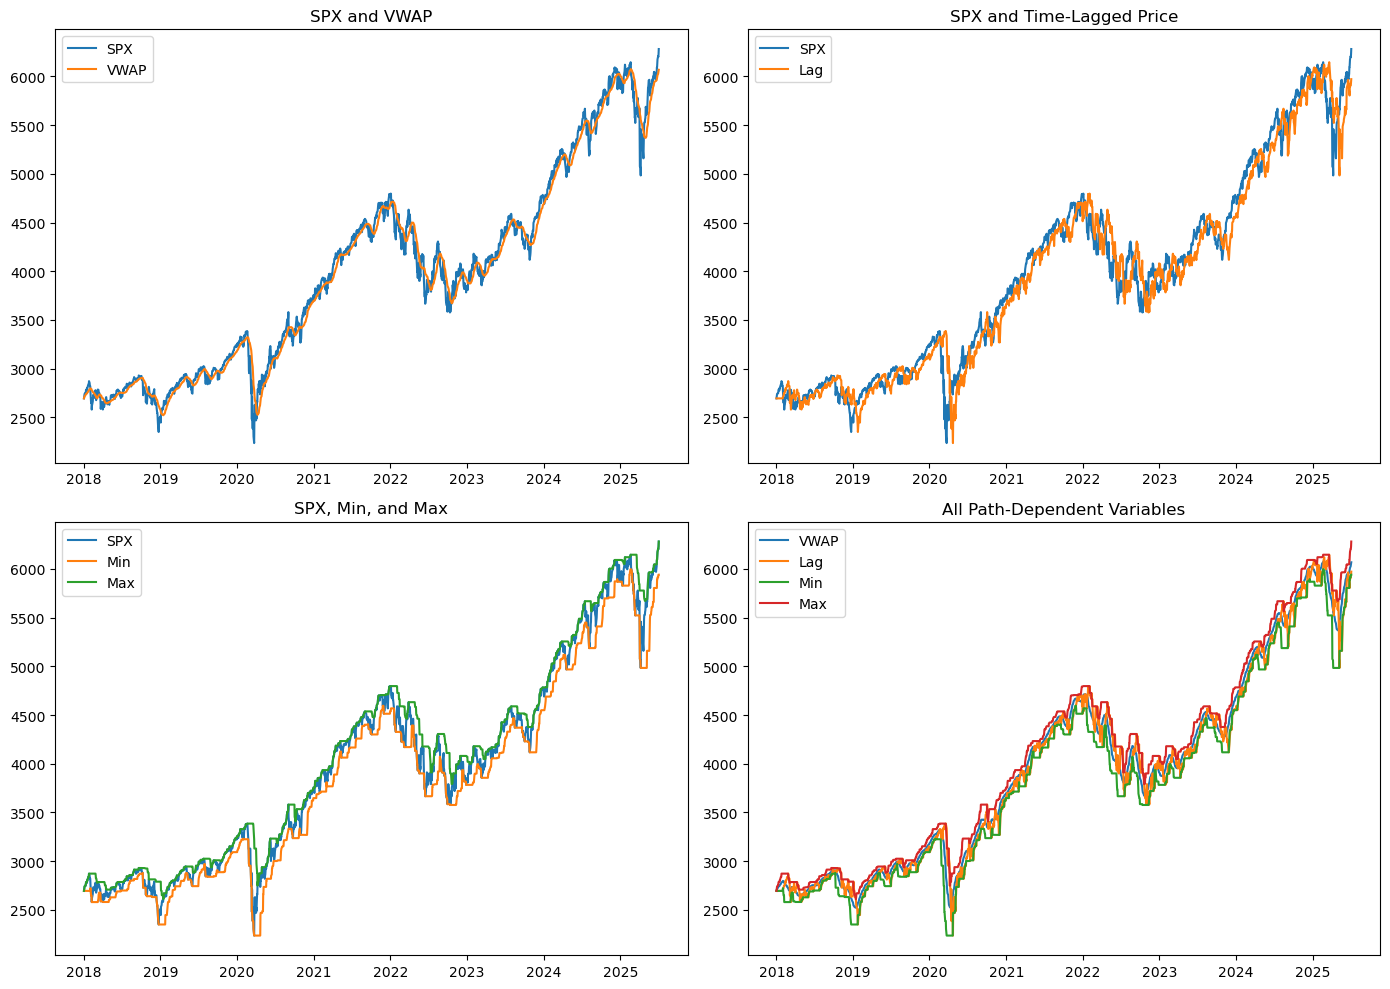

,SPX,VWAP,lag,min,max,sigma_type1,sigma_type2,sigma_type3,sigma_type4
2018-01-02,2695.810059,2695.810059,2695.810059,2695.810059,2695.810059,0.32,0.08,0.32,0.08
2018-01-03,2713.060059,2704.435059,2695.810059,2695.810059,2713.060059,0.08,0.08,0.08,0.08
2018-01-04,2723.989990,2710.953369,2695.810059,2695.810059,2723.989990,0.08,0.08,0.08,0.08
2018-01-05,2743.149902,2719.002502,2695.810059,2695.810059,2743.149902,0.08,0.08,0.08,0.08
2018-01-08,2747.709961,2724.743994,2695.810059,2695.810059,2747.709961,0.08,0.08,0.08,0.08


In [12]:
import datetime as dt

# Filter data for 2020-2025
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2025-07-07')  # Using the end date from your notebook
spx_filtered = spx.loc[start_date:end_date]

# Calculate business days between each data point (assuming trading days)
delta_days = np.diff(spx_filtered.index.values) / np.timedelta64(1, 'D')
delta_days = np.append(delta_days, 0)  # Add a zero for the last day
avg_dt = np.mean(delta_days[delta_days > 0])  # Average business days between observations
print(f"Average business days between observations: {avg_dt:.2f}")

# Parameters
Delta = 1/12  # 1 month window in years (as specified)
dt_annual = 1/252  # Assuming ~252 trading days per year
days_in_Delta = int(Delta * 252)  # Approximate number of trading days in Delta

print(f"Delta = {Delta} years, which is approximately {days_in_Delta} trading days")

# Initialize dataframe to store the results
results_df = pd.DataFrame(index=spx_filtered.index)
results_df['SPX'] = spx_filtered.values

# Function to calculate path-dependent variables
def calculate_pdv(prices, window_days):
    result = {}
    
    # VWAP (simple moving average as we don't have volume data)
    result['VWAP'] = prices.rolling(window=window_days, min_periods=1).mean()
    
    # Time lag
    result['lag'] = prices.shift(window_days).fillna(prices.iloc[0])
    
    # Min and max in the window
    result['min'] = prices.rolling(window=window_days, min_periods=1).min()
    result['max'] = prices.rolling(window=window_days, min_periods=1).max()
    
    return result

# Calculate path-dependent variables
pdv_results = calculate_pdv(results_df['SPX'], days_in_Delta)

# Add to results dataframe
for key, values in pdv_results.items():
    results_df[key] = values

# Plot the results
plt.figure(figsize=(14, 10))

# Plot SPX and VWAP
plt.subplot(2, 2, 1)
plt.plot(results_df.index, results_df['SPX'], label='SPX')
plt.plot(results_df.index, results_df['VWAP'], label='VWAP')
plt.title('SPX and VWAP')
plt.legend()

# Plot SPX and lag
plt.subplot(2, 2, 2)
plt.plot(results_df.index, results_df['SPX'], label='SPX')
plt.plot(results_df.index, results_df['lag'], label='Lag')
plt.title('SPX and Time-Lagged Price')
plt.legend()

# Plot SPX, min and max
plt.subplot(2, 2, 3)
plt.plot(results_df.index, results_df['SPX'], label='SPX')
plt.plot(results_df.index, results_df['min'], label='Min')
plt.plot(results_df.index, results_df['max'], label='Max')
plt.title('SPX, Min, and Max')
plt.legend()

# Plot all path-dependent variables
plt.subplot(2, 2, 4)
plt.plot(results_df.index, results_df['VWAP'], label='VWAP')
plt.plot(results_df.index, results_df['lag'], label='Lag')
plt.plot(results_df.index, results_df['min'], label='Min')
plt.plot(results_df.index, results_df['max'], label='Max')
plt.title('All Path-Dependent Variables')
plt.legend()

plt.tight_layout()
plt.show()

vol_cap = 0.32
vol_floor = 0.08

# Sigma type 1: σ(t,S,X) = vol_cap if S <= X (VWAP) else vol_floor
results_df['sigma_type1'] = np.where(results_df['SPX'] <= results_df['VWAP'], vol_cap, vol_floor)

# For sigma type 2, we need kappa and sigma0 parameters
kappa = 0.8
sigma0 = 0.2

threshold = kappa * sigma0 * np.sqrt(Delta)
results_df['sigma_type2'] = np.where(
    abs(results_df['SPX'] / results_df['VWAP'] - 1) > threshold,
    vol_cap,
    vol_floor
)

results_df['sigma_type3'] = np.where(
    (results_df['SPX'] - results_df['min']) / (results_df['max'] - results_df['min'] + 1e-8) <= 0.5,
    vol_cap,
    vol_floor
)

results_df['sigma_type4'] = np.where(
    (results_df['max'] / results_df['min'] - 1)  > threshold,
    vol_cap,
    vol_floor
)

results_df.head()


In [13]:
# Add future realized volatility to our results dataframe
results_df['future_rlsd_vol_5d'] = rlsd_vol.shift(-5)
results_df['rlsd_vol'] = rlsd_vol

results_df['SPX_returns'] = spx_returns
results_df['SPX_returns_squared'] = spx_returns**2

results_df['spx_vwap_ratio'] = results_df['SPX'] / results_df['VWAP']
results_df['abs_dev_from_vwap'] = abs(results_df['SPX'] / results_df['VWAP'] - 1)
results_df['rel_pos_in_range'] = (results_df['SPX'] - results_df['min']) / (results_df['max'] - results_df['min'] + 1e-8)
results_df['range_ratio'] = results_df['max'] / results_df['min'] - 1
model_df = results_df.dropna()

model_df.head(6)

,SPX,VWAP,lag,min,max,sigma_type1,sigma_type2,sigma_type3,sigma_type4,future_rlsd_vol_5d,rlsd_vol,SPX_returns,SPX_returns_squared,spx_vwap_ratio,abs_dev_from_vwap,rel_pos_in_range,range_ratio
2018-01-02,2695.810059,2695.810059,2695.810059,2695.810059,2695.810059,0.32,0.08,0.32,0.08,0.041745,0.077982,0.008303,0.000069,1.000000,0.000000,0.0,0.000000
2018-01-03,2713.060059,2704.435059,2695.810059,2695.810059,2713.060059,0.08,0.08,0.08,0.08,0.048954,0.083718,0.006399,0.000041,1.003189,0.003189,1.0,0.006399
2018-01-04,2723.989990,2710.953369,2695.810059,2695.810059,2723.989990,0.08,0.08,0.08,0.08,0.058301,0.082879,0.004029,0.000016,1.004809,0.004809,1.0,0.010453
2018-01-05,2743.149902,2719.002502,2695.810059,2695.810059,2743.149902,0.08,0.08,0.08,0.08,0.057142,0.086126,0.007034,0.000049,1.008881,0.008881,1.0,0.017561
2018-01-08,2747.709961,2724.743994,2695.810059,2695.810059,2747.709961,0.08,0.08,0.08,0.08,0.074689,0.041933,0.001662,0.000003,1.008429,0.008429,1.0,0.019252
2018-01-09,2751.290039,2729.168335,2695.810059,2695.810059,2751.290039,0.08,0.08,0.08,0.08,0.089949,0.041745,0.001303,0.000002,1.008106,0.008106,1.0,0.020580


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import itertools

# Define parameter grids for optimization
vol_cap_grid = np.linspace(0.2, 0.4, 10)  # Example range for volatility cap
vol_floor_grid = np.linspace(0.06, 0.15, 10)  # Example range for volatility floor
kappa_grid = np.linspace(0.2, 2, 10)  # Example range for kappa

# Lists to store results
results_linear = []
results_rf = []

# Function to create features based on parameters
def create_features(df, vol_cap, vol_floor, kappa):
    # Create a copy to avoid modifying the original
    temp_df = df.copy()

    # Sigma type 1: σ(t,S,X) = vol_cap if S <= X (VWAP) else vol_floor
    temp_df['sigma_type1'] = np.where(temp_df['SPX'] <= temp_df['VWAP'], vol_cap, vol_floor)
    
    # Sigma type 2: based on deviation of price from VWAP
    threshold = kappa * sigma0 * np.sqrt(Delta)
    temp_df['sigma_type2'] = np.where(
        abs(temp_df['SPX'] / temp_df['VWAP'] - 1) > threshold,
        vol_cap,
        vol_floor
    )
    
    # Sigma type 3: based on position within min-max range
    temp_df['sigma_type3'] = np.where(
        (temp_df['SPX'] - temp_df['min']) / (temp_df['max'] - temp_df['min'] + 1e-8) <= 0.5,
        vol_cap,
        vol_floor
    )
    
    # Sigma type 4: based on range
    temp_df['sigma_type4'] = np.where(
        (temp_df['max'] / temp_df['min'] - 1) > threshold,
        vol_cap,
        vol_floor
    )
    
    # Features for modeling - include the new factors
    features = temp_df[[
                'SPX', 
                'SPX_returns', 'SPX_returns_squared', 
                'rlsd_vol',
                'spx_vwap_ratio', 
                'abs_dev_from_vwap', 
                'rel_pos_in_range', 
                'range_ratio',
                'sigma_type1', 'sigma_type2', 'sigma_type3', 'sigma_type4'
            ]]
    target = temp_df['future_rlsd_vol_5d']
    
    return features, target

# Split data into train and test sets once
X_all, y_all = create_features(model_df, 0.32, 0.08, 0.8)  # Initial parameters
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Perform grid search
best_linear_mse = float('inf')
best_params_linear = None

total_combinations = len(vol_cap_grid) * len(vol_floor_grid) * len(kappa_grid)
print(f"Searching through {total_combinations} parameter combinations...")

for vol_cap, vol_floor, kappa in itertools.product(vol_cap_grid, vol_floor_grid, kappa_grid):
    # Create features with current parameters
    X_all, y_all = create_features(model_df, vol_cap, vol_floor, kappa)
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
    
    # Linear model
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    
    # Store results
    results_linear.append({
        'vol_cap': vol_cap, 
        'vol_floor': vol_floor, 
        'kappa': kappa, 
        'mse': mse_lr, 
        'r2': r2_lr
    })
    
    # Update best parameters
    if mse_lr < best_linear_mse:
        best_linear_mse = mse_lr
        best_params_linear = (vol_cap, vol_floor, kappa)

# Convert results to DataFrames for easier analysis
results_linear_df = pd.DataFrame(results_linear)

print("\nBest parameters for Linear model:")
print(f"vol_cap = {best_params_linear[0]}, vol_floor = {best_params_linear[1]}, kappa = {best_params_linear[2]}")
print(f"MSE: {best_linear_mse:.6f}, R²: {results_linear_df.loc[results_linear_df['mse'] == best_linear_mse, 'r2'].values[0]:.6f}")

Searching through 1000 parameter combinations...

Best parameters for Linear model:
vol_cap = 0.35555555555555557, vol_floor = 0.1, kappa = 1.2
MSE: 0.007822, R²: 0.641949

Best parameters for Linear model:
vol_cap = 0.35555555555555557, vol_floor = 0.1, kappa = 1.2
MSE: 0.007822, R²: 0.641949


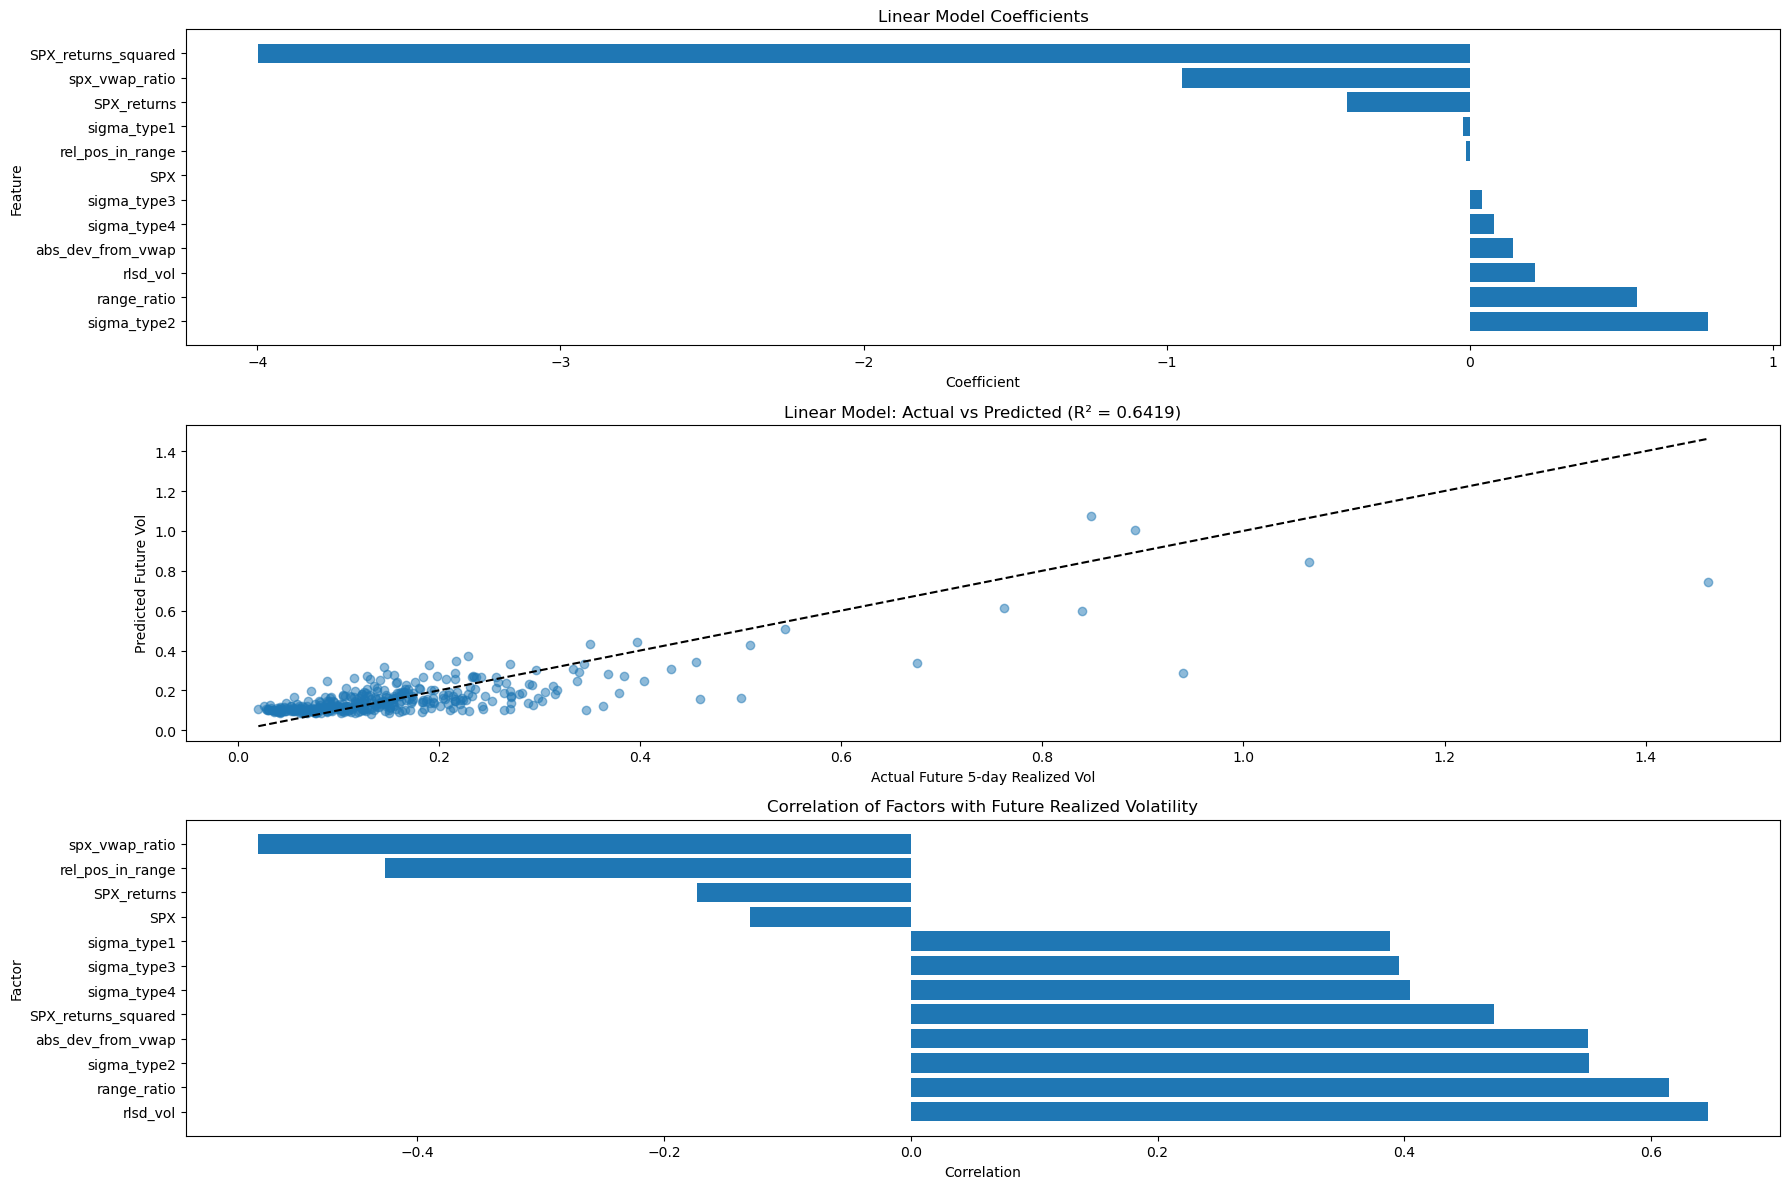

In [29]:
# Best Linear model
best_vol_cap_lr, best_vol_floor_lr, best_kappa_lr = best_params_linear
X_best_lr, y_best_lr = create_features(model_df, best_vol_cap_lr, best_vol_floor_lr, best_kappa_lr)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_best_lr, y_best_lr, test_size=0.2, random_state=42)

best_lr = LinearRegression()
best_lr.fit(X_train_lr, y_train_lr)
linear_coefficients = pd.DataFrame({
    'Feature': X_best_lr.columns,
    'Coefficient': best_lr.coef_
}).sort_values(by='Coefficient', ascending=False)

y_pred_lr = best_lr.predict(X_test_lr)

# Create visualizations
plt.figure(figsize=(18, 12))

# Plot coefficients
plt.subplot(3, 1, 1)
plt.barh(linear_coefficients['Feature'], linear_coefficients['Coefficient'])
plt.title('Linear Model Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')

# Plot actual vs predicted for Linear Regression
plt.subplot(3, 1, 2)
plt.scatter(y_test_lr, y_pred_lr, alpha=0.5)
plt.plot([y_test_lr.min(), y_test_lr.max()], [y_test_lr.min(), y_test_lr.max()], 'k--')
plt.xlabel('Actual Future 5-day Realized Vol')
plt.ylabel('Predicted Future Vol')
plt.title(f'Linear Model: Actual vs Predicted (R² = {r2_score(y_test_lr, y_pred_lr):.4f})')

# Plot the correlation between new factors and future volatility
plt.subplot(3, 1, 3)
factor_corrs = X_best_lr.corrwith(y_best_lr).sort_values(ascending=False)
plt.barh(factor_corrs.index, factor_corrs.values)
plt.title('Correlation of Factors with Future Realized Volatility')
plt.xlabel('Correlation')
plt.ylabel('Factor')

plt.tight_layout()
plt.show()

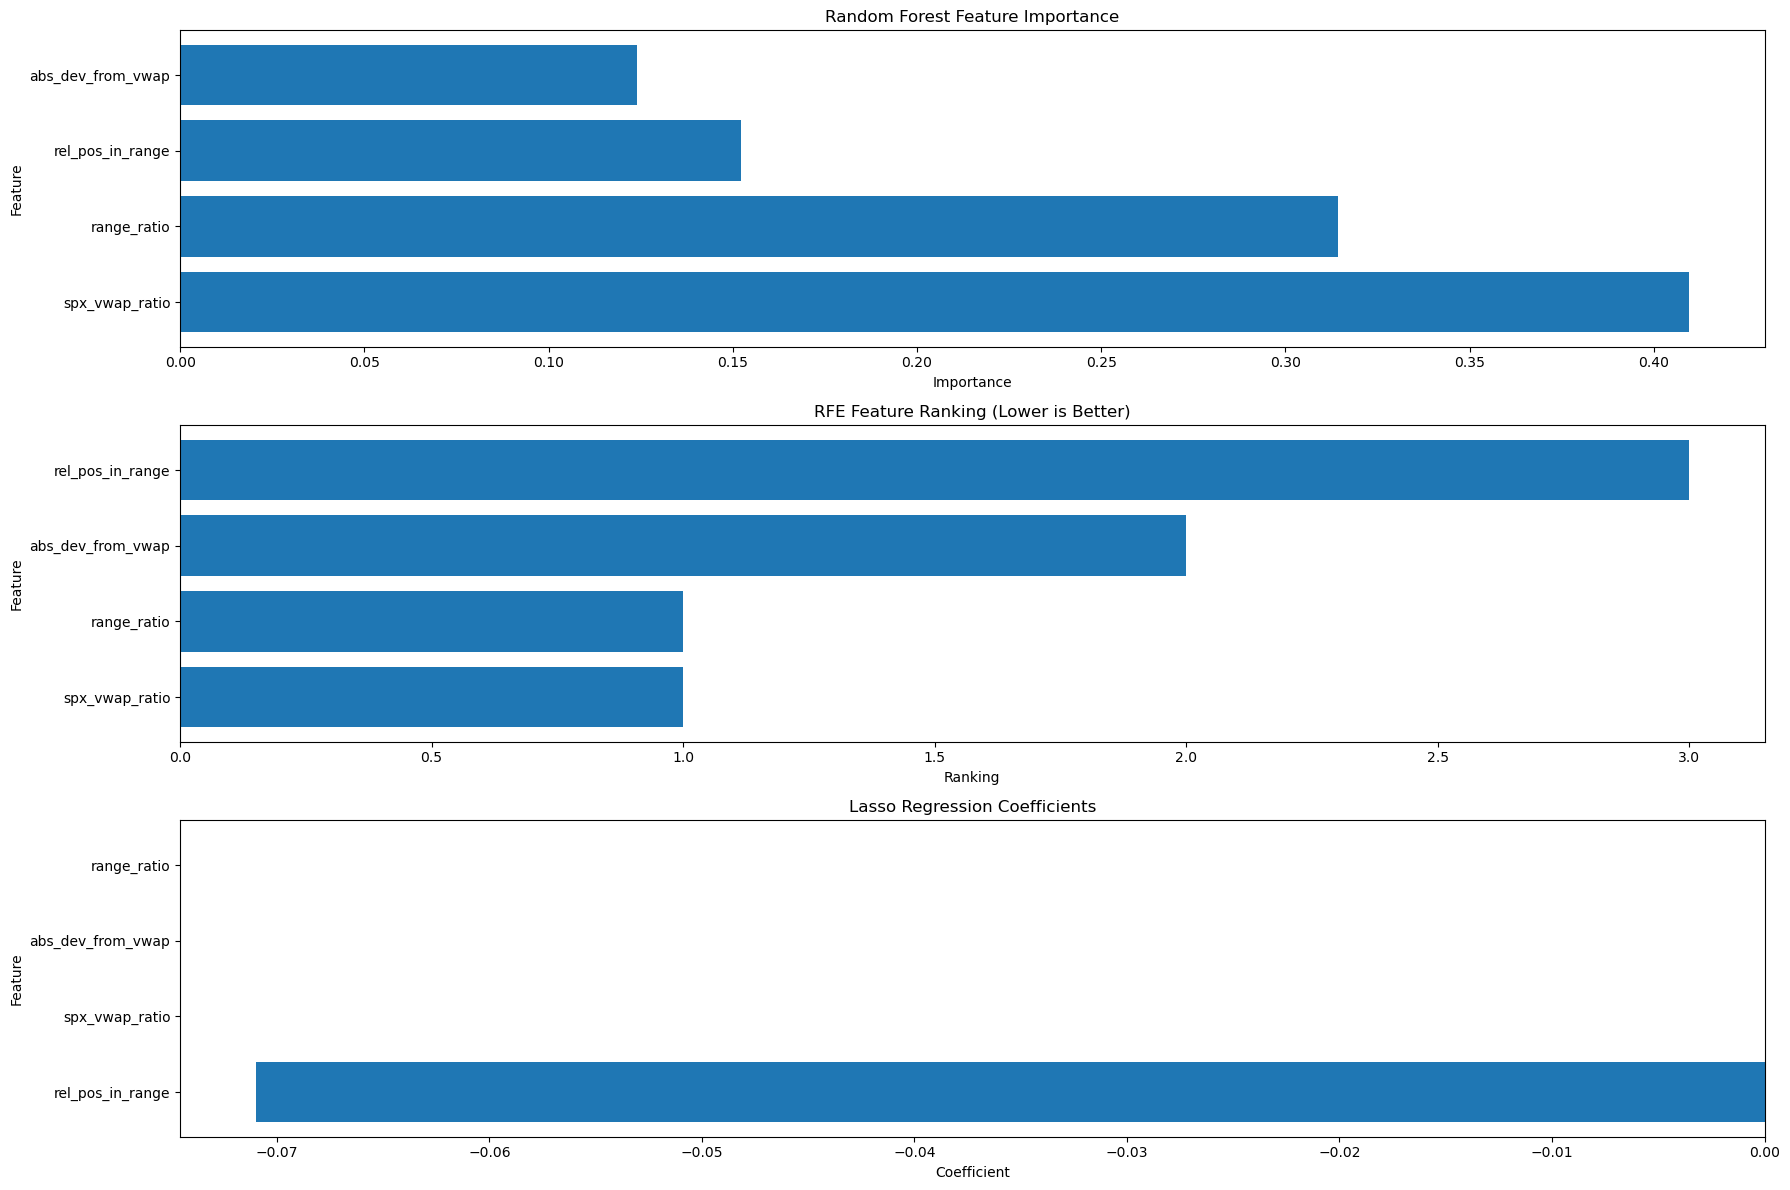

Model comparison:
Original features - MSE: 0.008050, R²: 0.631483
All features (including new factors) - MSE: 0.007822, R²: 0.641949
Improvement in MSE: 2.84%
Improvement in R²: 1.66%


In [30]:
# Feature importance analysis for the new factors
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso

# Create a dataset with only the new factors for analysis
X_new_factors = X_best_lr[['spx_vwap_ratio', 'abs_dev_from_vwap', 'rel_pos_in_range', 'range_ratio']]
X_train_nf, X_test_nf, y_train_nf, y_test_nf = train_test_split(X_new_factors, y_best_lr, test_size=0.2, random_state=42)

# 1. Random Forest feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_nf, y_train_nf)
rf_importances = pd.DataFrame({
    'Feature': X_new_factors.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 2. Recursive Feature Elimination
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=2)
rfe.fit(X_train_nf, y_train_nf)
rfe_ranking = pd.DataFrame({
    'Feature': X_new_factors.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

# 3. Lasso Regression (L1 regularization for feature selection)
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_nf, y_train_nf)
lasso_coefs = pd.DataFrame({
    'Feature': X_new_factors.columns,
    'Coefficient': lasso.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Visualize the feature importance analysis
plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
plt.barh(rf_importances['Feature'], rf_importances['Importance'])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.subplot(3, 1, 2)
plt.barh(rfe_ranking['Feature'], rfe_ranking['Ranking'])
plt.title('RFE Feature Ranking (Lower is Better)')
plt.xlabel('Ranking')
plt.ylabel('Feature')

plt.subplot(3, 1, 3)
plt.barh(lasso_coefs['Feature'], lasso_coefs['Coefficient'])
plt.title('Lasso Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

# Compare models with and without new factors
# Original features
X_orig = X_best_lr[['SPX', 'SPX_returns', 'SPX_returns_squared', 'rlsd_vol', 
                   'sigma_type1', 'sigma_type2', 'sigma_type3', 'sigma_type4']]
# All features
X_all_feat = X_best_lr

# Split data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_orig, y_best_lr, test_size=0.2, random_state=42)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all_feat, y_best_lr, test_size=0.2, random_state=42)

# Train models
lr_orig = LinearRegression().fit(X_train_orig, y_train_orig)
lr_all = LinearRegression().fit(X_train_all, y_train_all)

# Evaluate models
orig_mse = mean_squared_error(y_test_orig, lr_orig.predict(X_test_orig))
orig_r2 = r2_score(y_test_orig, lr_orig.predict(X_test_orig))
all_mse = mean_squared_error(y_test_all, lr_all.predict(X_test_all))
all_r2 = r2_score(y_test_all, lr_all.predict(X_test_all))

print("Model comparison:")
print(f"Original features - MSE: {orig_mse:.6f}, R²: {orig_r2:.6f}")
print(f"All features (including new factors) - MSE: {all_mse:.6f}, R²: {all_r2:.6f}")
print(f"Improvement in MSE: {(orig_mse - all_mse) / orig_mse * 100:.2f}%")
print(f"Improvement in R²: {(all_r2 - orig_r2) / orig_r2 * 100:.2f}%")

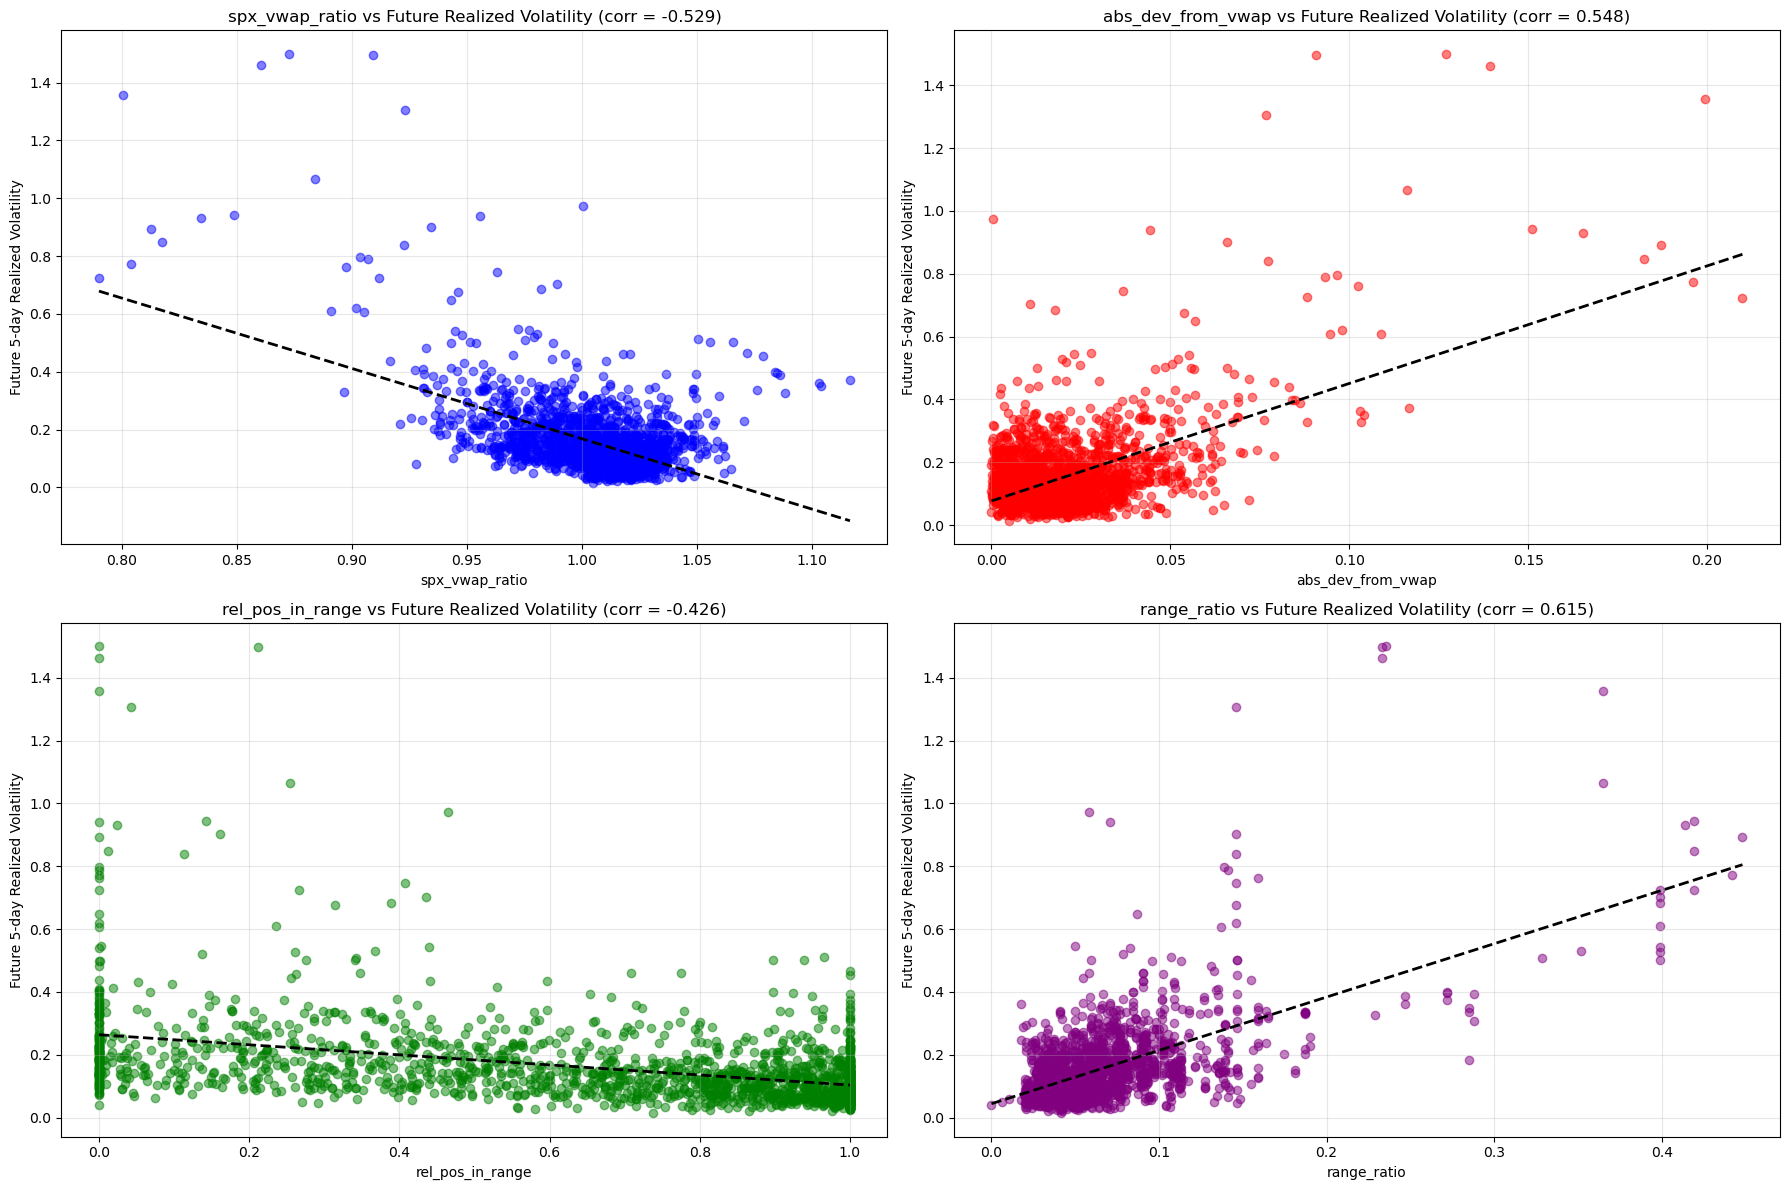

In [31]:
# Create scatter plots to visualize relationships between new factors and future volatility
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

factors = ['spx_vwap_ratio', 'abs_dev_from_vwap', 'rel_pos_in_range', 'range_ratio']
colors = ['blue', 'red', 'green', 'purple']

# Create a DataFrame for plotting that includes the target variable
plot_df = X_best_lr.copy()
plot_df['future_rlsd_vol_5d'] = y_best_lr

for i, factor in enumerate(factors):
    # Simple scatter plot
    axes[i].scatter(plot_df[factor], plot_df['future_rlsd_vol_5d'], 
                   alpha=0.5, color=colors[i])
    
    # Add trend line
    z = np.polyfit(plot_df[factor], plot_df['future_rlsd_vol_5d'], 1)
    p = np.poly1d(z)
    axes[i].plot(sorted(plot_df[factor]), p(sorted(plot_df[factor])), 
                'k--', linewidth=2)
    
    # Calculate correlation coefficient
    corr = plot_df[factor].corr(plot_df['future_rlsd_vol_5d'])
    
    axes[i].set_title(f'{factor} vs Future Realized Volatility (corr = {corr:.3f})')
    axes[i].set_xlabel(factor)
    axes[i].set_ylabel('Future 5-day Realized Volatility')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Method 1: Applying nonlinear transformations


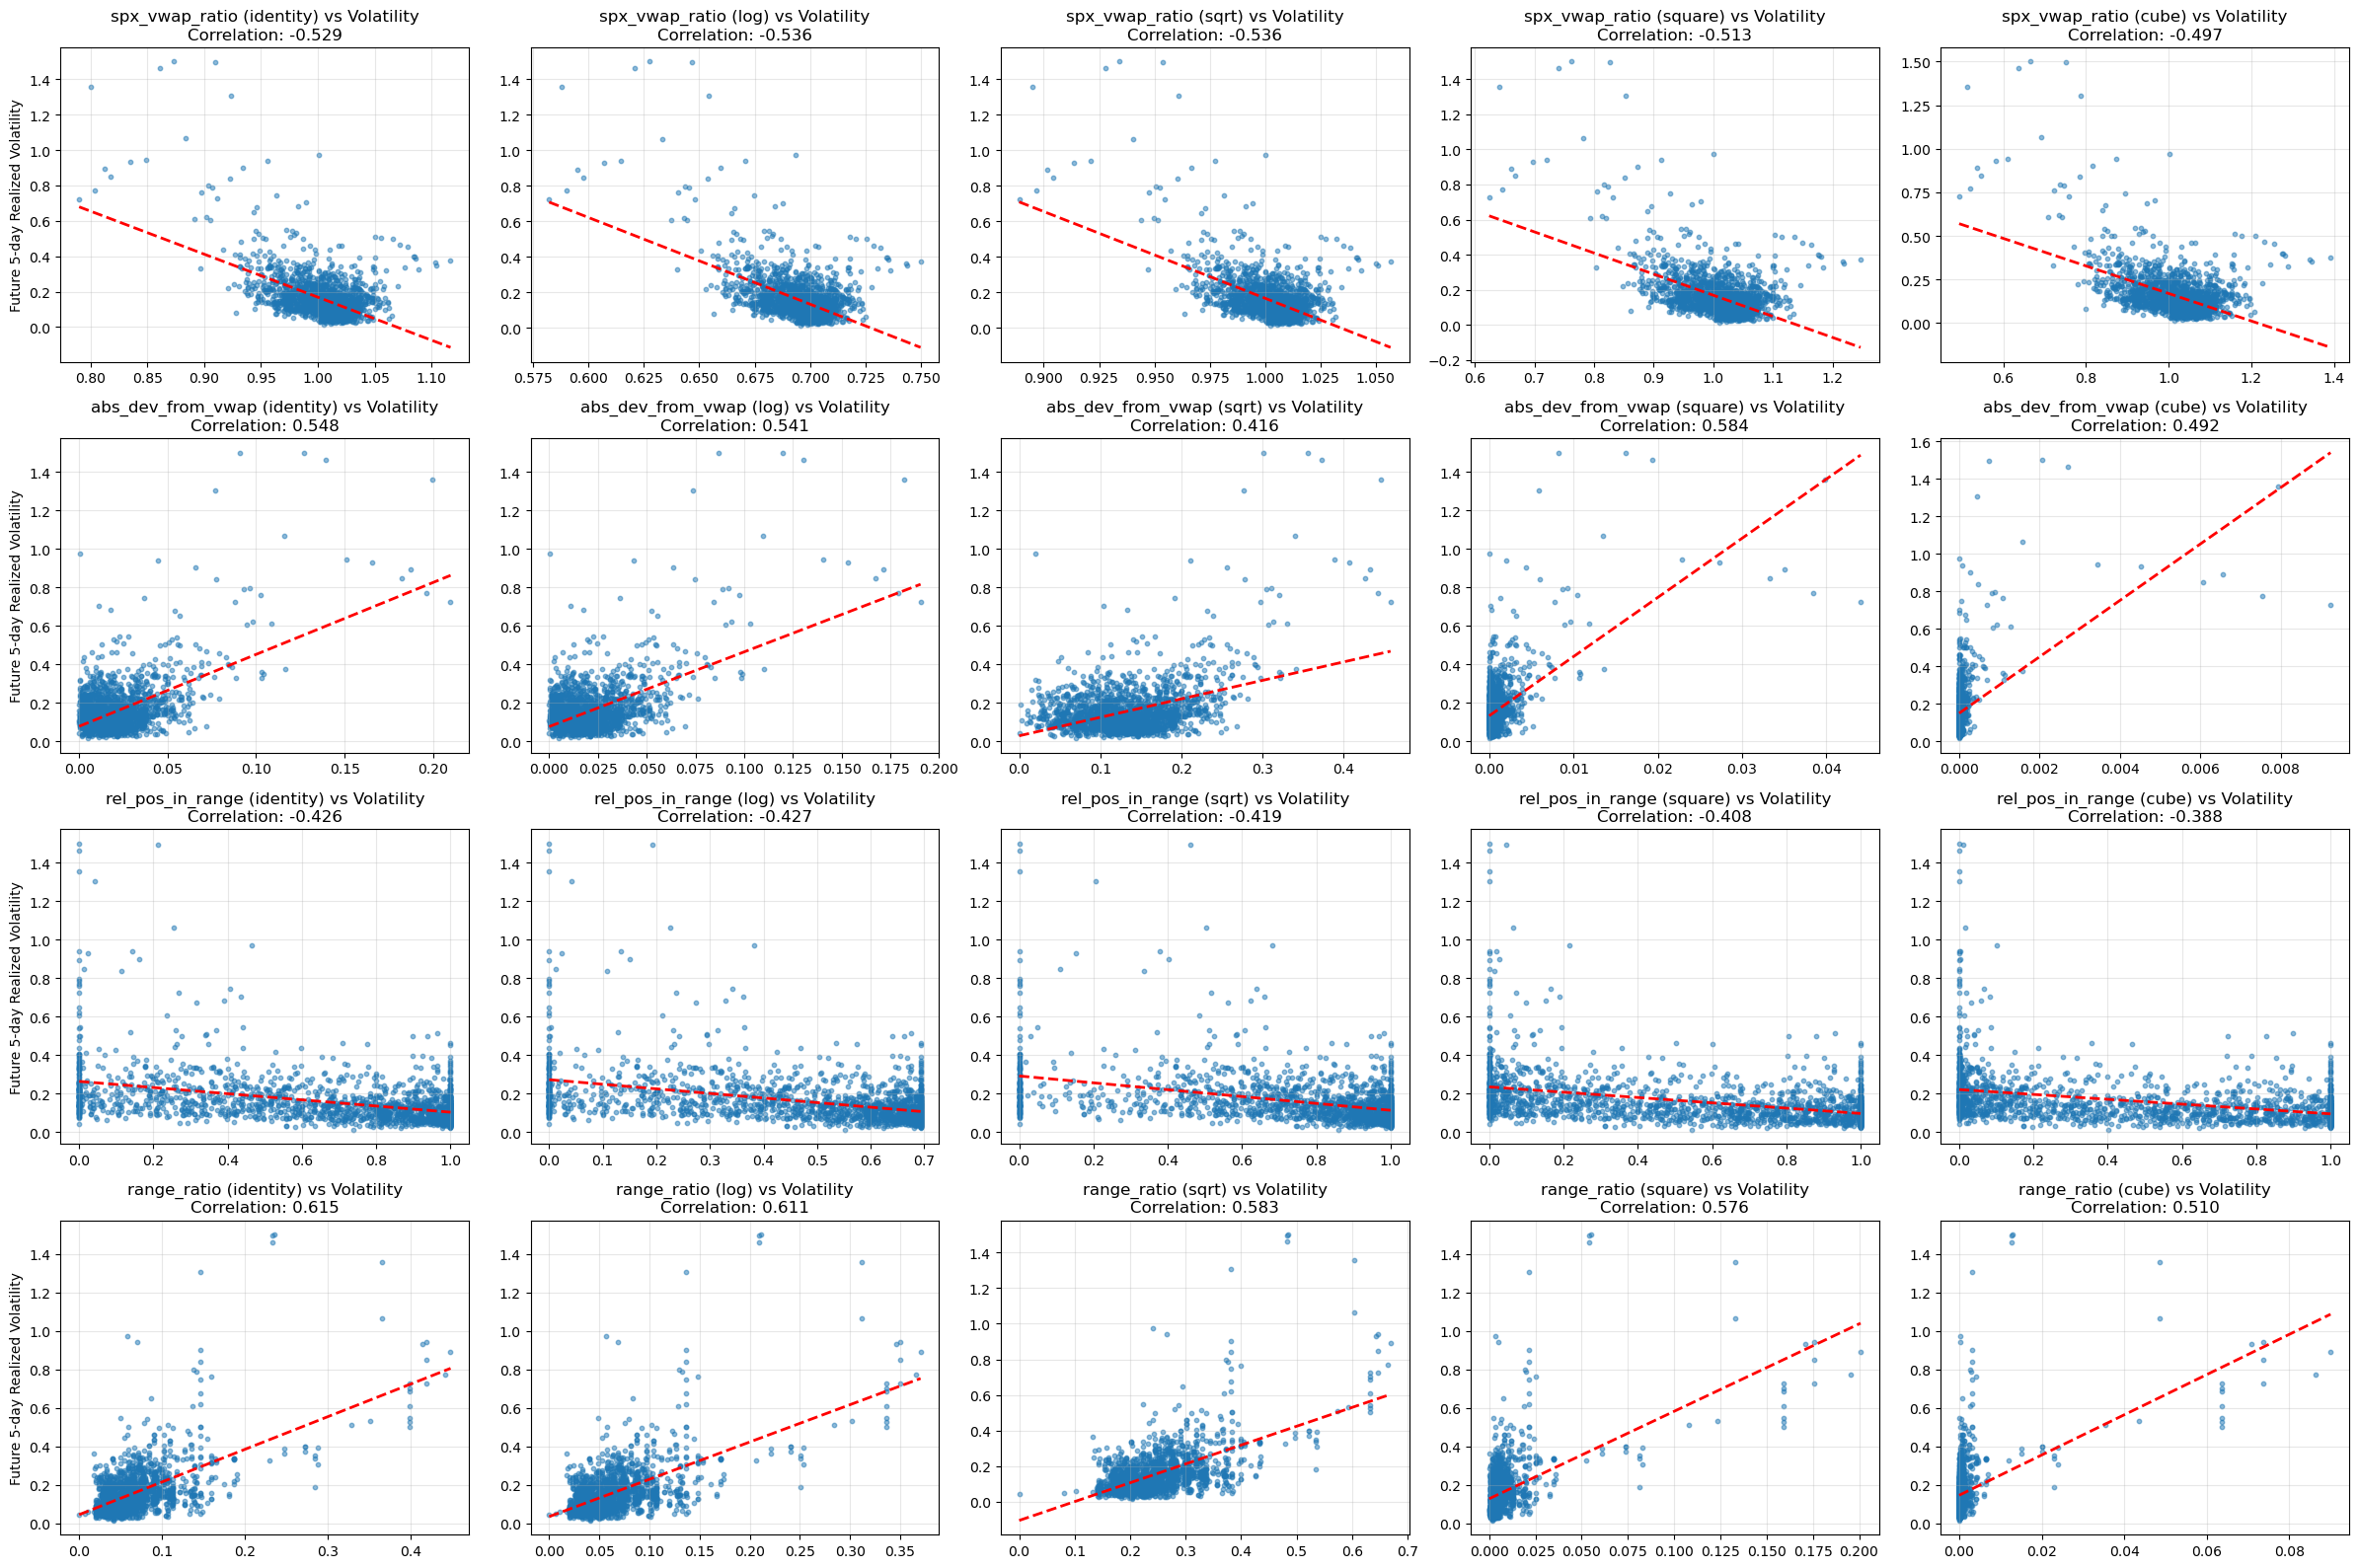

In [32]:
# Methods for handling nonlinear relationships and clustered data

# Method 1: Apply nonlinear transformations
print("Method 1: Applying nonlinear transformations")
transformed_factors = ['spx_vwap_ratio', 'abs_dev_from_vwap', 'rel_pos_in_range', 'range_ratio']
transformations = {
    'identity': lambda x: x,                                 # Original (no transformation) for comparison
    'log': lambda x: np.log1p(x) if np.all(x >= 0) else x,  # log(1+x) to avoid negative or zero values
    'sqrt': lambda x: np.sqrt(x) if np.all(x >= 0) else x,   # Square root transformation
    'square': lambda x: x**2,                                # Square transformation
    'cube': lambda x: x**3,                                  # Cube transformation
}

fig, axes = plt.subplots(len(transformed_factors), len(transformations), figsize=(24, 16))

for i, factor in enumerate(transformed_factors):
    for j, (name, transform) in enumerate(transformations.items()):
        try:
            transformed_values = transform(plot_df[factor])
            
            # Check if transformed values are valid
            if np.any(np.isnan(transformed_values)) or np.any(np.isinf(transformed_values)):
                axes[i, j].text(0.5, 0.5, f"Transformation produced invalid values", ha='center')
                continue
                
            # Calculate correlation
            corr = np.corrcoef(transformed_values, plot_df['future_rlsd_vol_5d'])[0, 1]
            
            # Draw scatter plot
            axes[i, j].scatter(transformed_values, plot_df['future_rlsd_vol_5d'], 
                            alpha=0.5, s=10)
            
            # Add trend line
            z = np.polyfit(transformed_values, plot_df['future_rlsd_vol_5d'], 1)
            p = np.poly1d(z)
            x_sorted = np.sort(transformed_values)
            axes[i, j].plot(x_sorted, p(x_sorted), 'r--', linewidth=2)
            
            axes[i, j].set_title(f'{factor} ({name}) vs Volatility\nCorrelation: {corr:.3f}')
            axes[i, j].grid(True, alpha=0.3)
            
            if j == 0:
                axes[i, j].set_ylabel('Future 5-day Realized Volatility')
        except Exception as e:
            axes[i, j].text(0.5, 0.5, f"Error: {str(e)}", ha='center')

plt.tight_layout()
plt.show()